In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.multioutput import MultiOutputRegressor


### Análisis de Ventas

In [13]:
flights = pd.read_csv(r"Filghts_train_test.csv")
sales = pd.read_csv(r"Sales_train_test.csv")
vuelos = flights.merge(sales.drop(columns='TotalSales'), on = 'Flight_ID', how = 'left')

# Columnas de fecha en formato datetime
vuelos['STD'] = pd.to_datetime(vuelos['STD'])
vuelos['STA'] = pd.to_datetime(vuelos['STA'])

vuelos['Day_of_Week'] = vuelos['STD'].dt.dayofweek
vuelos['Month'] = pd.to_datetime(vuelos['STD']).dt.month

Q1 = vuelos['Quantity'].quantile(0.25)
Q3 = vuelos['Quantity'].quantile(0.75)
IQR = Q3 - Q1

# Límites para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar outliers
vuelos_filtrados = vuelos[(vuelos['Quantity'] >= lower_bound) & (vuelos['Quantity'] <= upper_bound)]

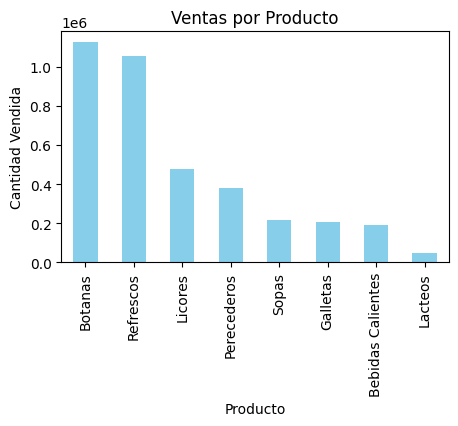

In [14]:
# Agrupar por producto y sumar las cantidades vendidas
ventas_por_tipo_producto = vuelos_filtrados.groupby('ProductType')['Quantity'].sum()

# Ordenar los resultados para ver los productos más vendidos
ventas_por_tipo_producto_sorted = ventas_por_tipo_producto.sort_values(ascending=False)

# Gráfico de barras de las ventas por producto
plt.figure(figsize=(5, 3))
ventas_por_tipo_producto_sorted.plot(kind='bar', color='skyblue')
plt.title('Ventas por Producto')
plt.xlabel('Producto')
plt.ylabel('Cantidad Vendida')
plt.xticks(rotation=90)
plt.show()


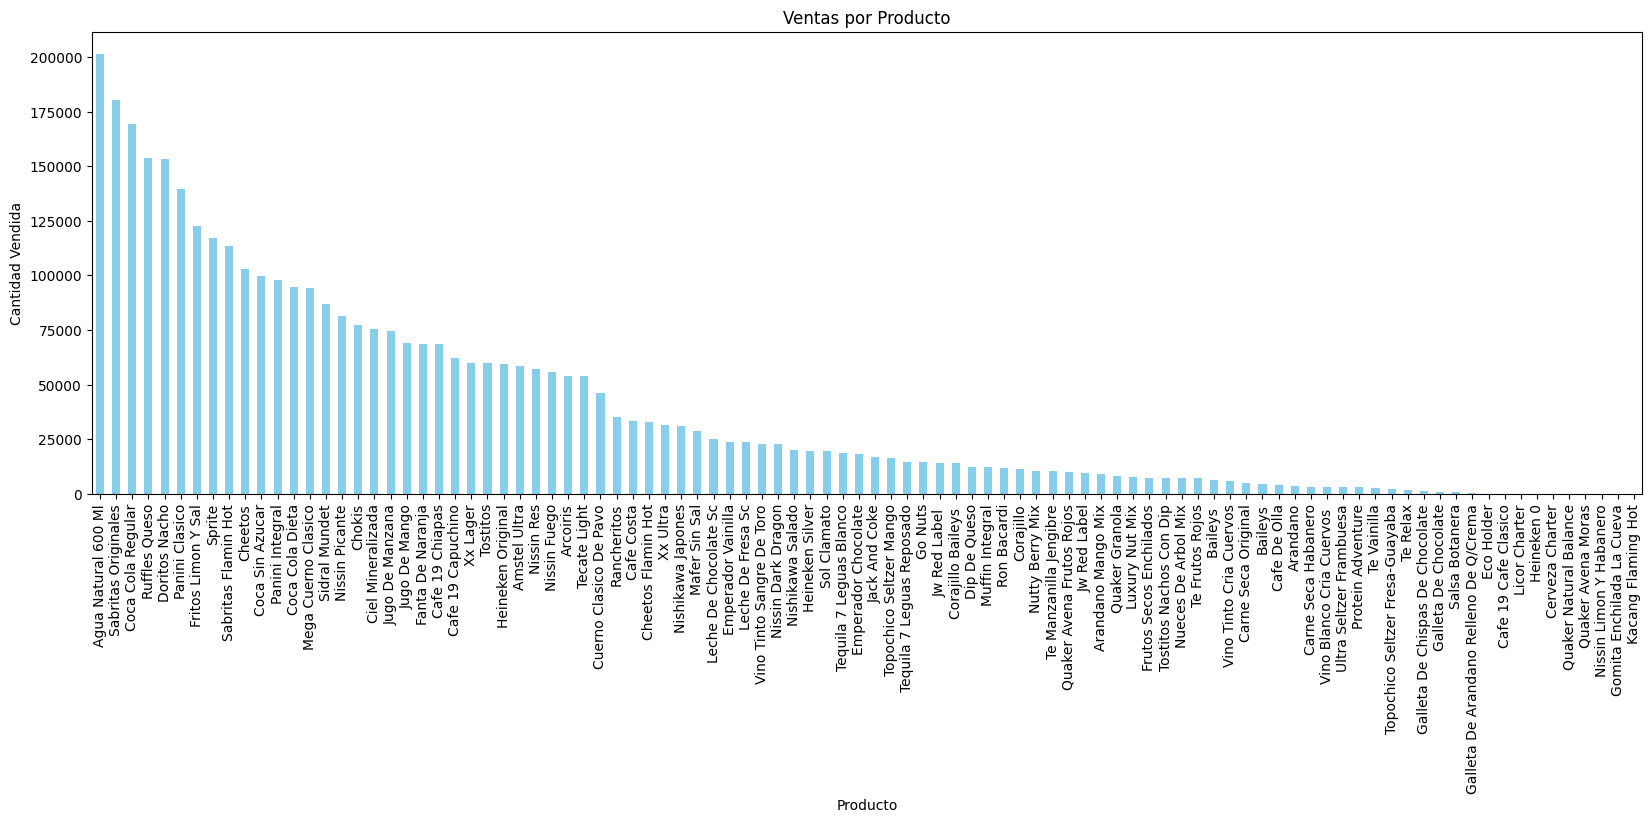

In [15]:
# Agrupar por ProductName y sumar las cantidades vendidas
ventas_por_producto = vuelos_filtrados.groupby('ProductName')['Quantity'].sum()

# Ordenar los resultados para ver los productos más vendidos
ventas_por_producto_sorted = ventas_por_producto.sort_values(ascending=False)

# Gráfico de barras de las ventas por producto
plt.figure(figsize=(20, 6))
ventas_por_producto_sorted.plot(kind='bar', color='skyblue')
plt.title('Ventas por Producto')
plt.xlabel('Producto')
plt.ylabel('Cantidad Vendida')
plt.xticks(rotation=90)
plt.show()

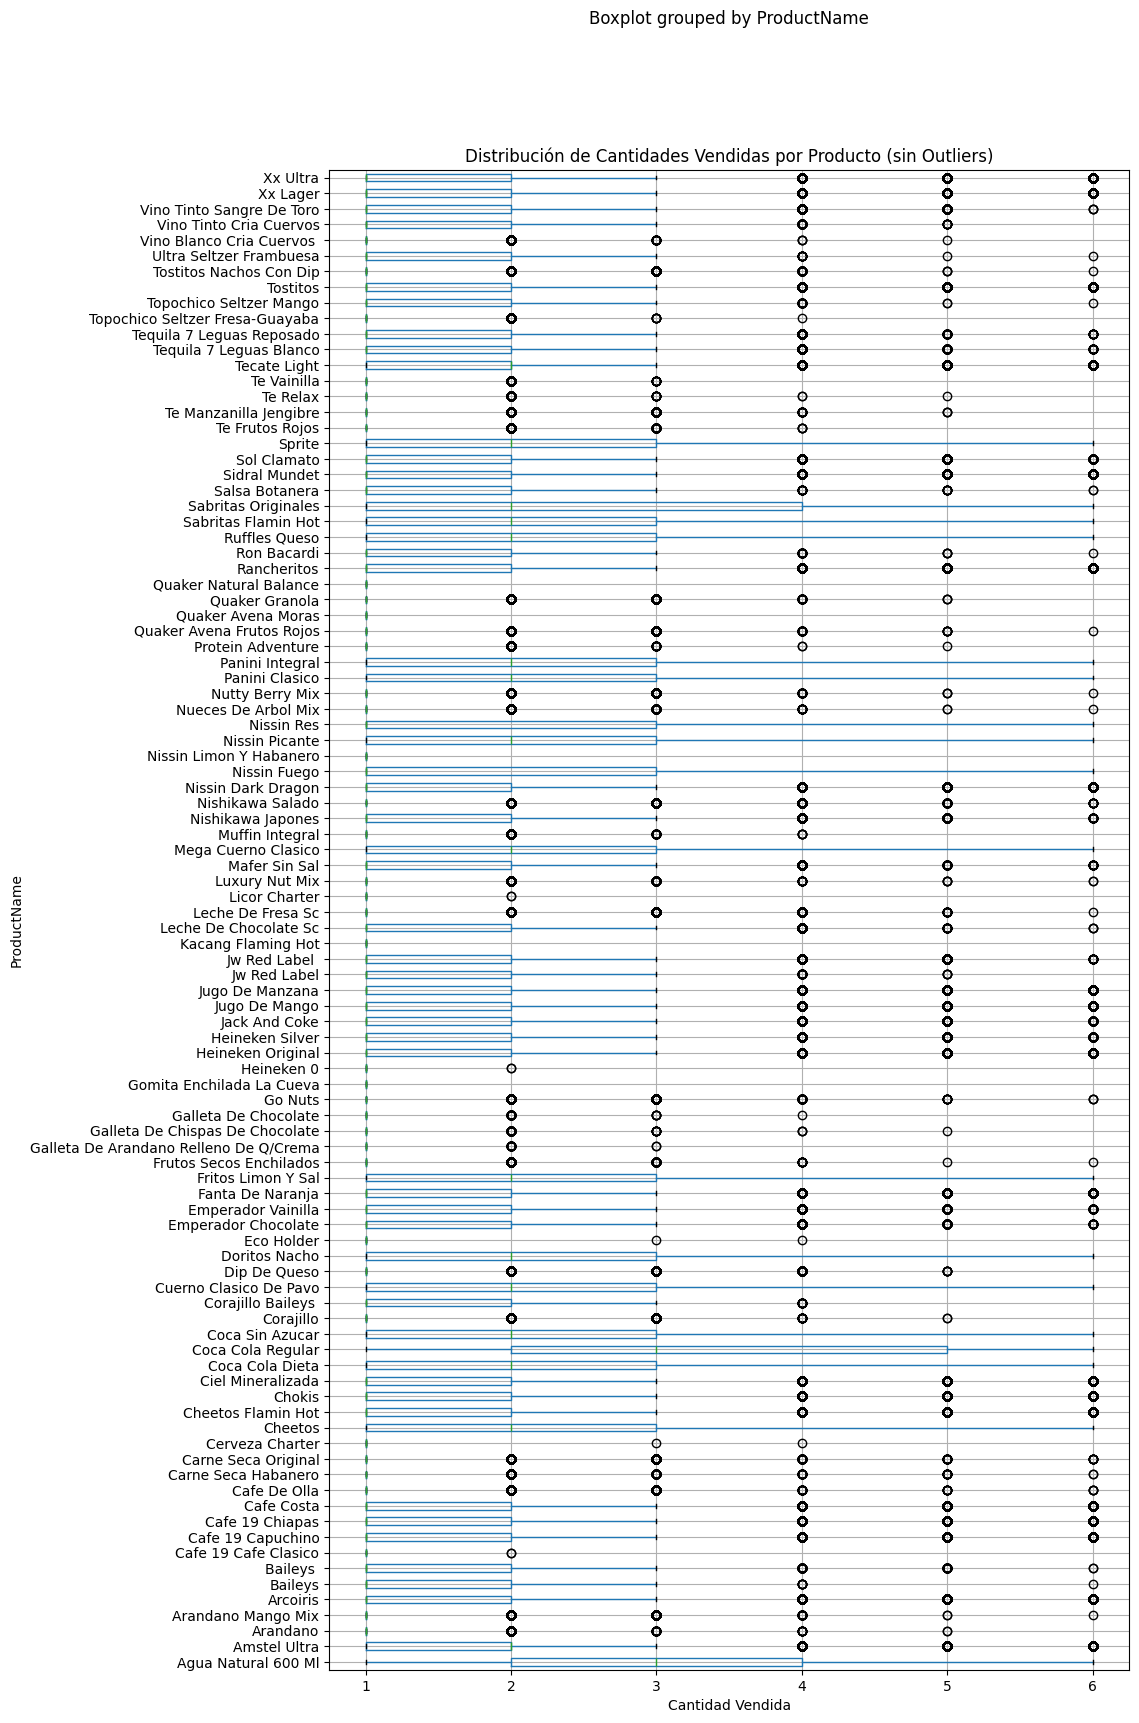

In [16]:
vuelos_filtrados.boxplot(column='Quantity', by='ProductName', vert=False, figsize=(10,20))
plt.title('Distribución de Cantidades Vendidas por Producto (sin Outliers)')
plt.xlabel('Cantidad Vendida')
plt.show()

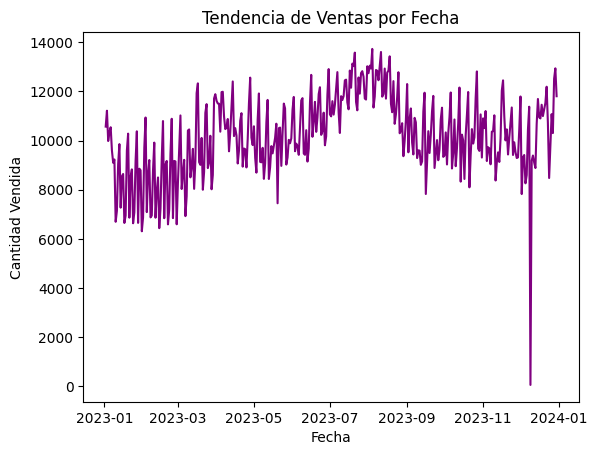

In [17]:
# Agrupar por fecha y sumar las ventas
ventas_por_fecha = vuelos_filtrados.groupby(vuelos_filtrados['STD'].dt.date)['Quantity'].sum()

# Gráfico de series temporales de las ventas
ventas_por_fecha.plot(kind='line', color='purple')
plt.title('Tendencia de Ventas por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.show()


In [ ]:
X = vuelos.set_index('Flight_ID')[['Capacity', 'Month', 'Day_of_Week', 'Hour of Day', 'Duration', 'Destination_Type', 'DepartureStation', 'ArrivalStation', 'Aeronave',  'Ocupancia']]
y = pd.pivot_table(vuelos, index='Flight_ID', columns='ProductName', values='Quantity', fill_value=0)

# Codificar variables categóricas usando get_dummies
X = pd.get_dummies(X, columns=['Destination_Type', 'DepartureStation', 'ArrivalStation', 'Aeronave'])

# Asegurarse de que ambos X e y tienen exactamente los mismos índices
X = X.loc[y.index]
y = y.loc[X.index]

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo MultiOutput
multioutput_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=1, random_state=42, n_jobs=-1))
multioutput_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = multioutput_model.predict(X_test)

In [56]:
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error(MAE):",mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error(MSE):",mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):",rmse)

r2 = r2_score(y_test, y_pred)
print("R^2:",r2)

Mean Absolute Error(MAE): 0.008831871596458749
Mean Squared Error(MSE): 0.01889755632919985
Root Mean Squared Error (RMSE): 0.1374683830166044
R^2: 0.9893462716391038


In [57]:
pred_df = pd.DataFrame(np.round(y_pred), columns=y_test.columns, index=y_test.index)
pred_df

ProductName,Agua Natural 600 Ml,Amstel Ultra,Arandano,Arandano Mango Mix,Arcoiris,Baileys,Baileys,Cafe 19 Cafe Clasico,Cafe 19 Capuchino,Cafe 19 Chiapas,...,Topochico Seltzer Fresa-Guayaba,Topochico Seltzer Mango,Tostitos,Tostitos Nachos Con Dip,Ultra Seltzer Frambuesa,Vino Blanco Cria Cuervos,Vino Tinto Cria Cuervos,Vino Tinto Sangre De Toro,Xx Lager,Xx Ultra
Flight_ID,,,,,,,,,,,,,,,,,,,,,
c972e4402c8791e49420f18908d0ebf4,17.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89547707b296cd30a3a4937f5716601e,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
e18f4ace6db4b599c8ad425e91b93a75,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
b04cd06b7de383a57650b4a58193229d,7.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2f8d6fe9e4406b9fedc421633acef630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2a43ad37e41f3bf307e09e57dd55883e,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
63a8d0da16e9cb25aa7b1bd7f2110a76,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2d592a5f6c974ee6398fda381807f438,8.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,6.0,...,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [33]:
# Guardar el modelo en un archivo binario
with open('Modelo_Ventas.pkl', 'wb') as file:
    pickle.dump(multioutput_model, file)

### Pronóstico mes de enero

In [132]:
test_f_data = pd.read_csv("Flights_pred.csv")
test_s_data = pd.read_csv("Sales_pred.csv")

test_vuelos = test_f_data.merge(test_s_data, on = 'Flight_ID', how = 'left')
test_vuelos['Ocupancia'] = test_vuelos['Passengers'] / test_vuelos['Capacity']

test_vuelos['STD'] = pd.to_datetime(test_vuelos['STD'])
test_vuelos['STA'] = pd.to_datetime(test_vuelos['STA'])
test_vuelos['Month'] = test_vuelos['STD'].dt.month
test_vuelos['Day_of_Week'] = test_vuelos['STD'].dt.dayofweek
test_vuelos = test_vuelos[~test_vuelos['Aeronave'].isna()]

In [164]:
X = test_vuelos.set_index('Flight_ID')[['Capacity', 'Month', 'Day_of_Week', 'Hour of Day',
                                        'Duration', 'Destination_Type', 'DepartureStation', 'ArrivalStation', 'Aeronave',  'Ocupancia']]
y = pd.pivot_table(test_vuelos, index='Flight_ID', columns='ProductName', values='Quantity', fill_value=0)

# Codificar variables categóricas usando get_dummies
X = pd.get_dummies(X, columns=['Destination_Type', 'DepartureStation', 'ArrivalStation', 'Aeronave'])

indices = list(set(X.index).intersection(set(y.index)))

# Asegurarse de que ambos X e y tienen exactamente los mismos índices
X = X.loc[indices]
y = y.loc[indices]

for column in X_test.columns:
    if column not in X.columns:
        X[column] = 0
        
X = X[['Capacity', 'Month', 'Day_of_Week', 'Hour of Day', 'Duration', 'Ocupancia', 'Destination_Type_Ciudad Fronteriza', 'Destination_Type_Ciudad Principal',
   'Destination_Type_Ecoturismo', 'Destination_Type_MX Amigos y Familia', 'Destination_Type_Playa', 'DepartureStation_AB', 'DepartureStation_AC', 'DepartureStation_AD',
   'DepartureStation_AE', 'DepartureStation_AF', 'DepartureStation_AI', 'DepartureStation_AJ', 'DepartureStation_AK', 'DepartureStation_AL', 'DepartureStation_AM', 'DepartureStation_AO',
   'DepartureStation_AP', 'DepartureStation_AQ', 'DepartureStation_AR', 'DepartureStation_AS', 'DepartureStation_AT', 'DepartureStation_AU', 'DepartureStation_AV', 'DepartureStation_AW',
   'DepartureStation_AX', 'DepartureStation_AY', 'DepartureStation_AZ', 'DepartureStation_BA', 'DepartureStation_BB', 'DepartureStation_BC', 'DepartureStation_BD', 'DepartureStation_BE',
   'DepartureStation_BF', 'DepartureStation_BG', 'DepartureStation_BH', 'DepartureStation_BI', 'DepartureStation_BJ', 'DepartureStation_BK', 'DepartureStation_BL', 'DepartureStation_BM',
   'DepartureStation_BN', 'DepartureStation_BO', 'DepartureStation_BP', 'DepartureStation_BQ', 'DepartureStation_BS', 'DepartureStation_BT', 'ArrivalStation_AB', 'ArrivalStation_AC', 'ArrivalStation_AD',
   'ArrivalStation_AE', 'ArrivalStation_AF', 'ArrivalStation_AI', 'ArrivalStation_AJ', 'ArrivalStation_AK', 'ArrivalStation_AL', 'ArrivalStation_AM', 'ArrivalStation_AO', 'ArrivalStation_AP',
   'ArrivalStation_AQ', 'ArrivalStation_AR', 'ArrivalStation_AS', 'ArrivalStation_AT', 'ArrivalStation_AU', 'ArrivalStation_AV', 'ArrivalStation_AW', 'ArrivalStation_AX', 'ArrivalStation_AY',
   'ArrivalStation_AZ', 'ArrivalStation_BA', 'ArrivalStation_BB', 'ArrivalStation_BC', 'ArrivalStation_BD', 'ArrivalStation_BE', 'ArrivalStation_BF', 'ArrivalStation_BG', 'ArrivalStation_BH',
   'ArrivalStation_BI', 'ArrivalStation_BJ', 'ArrivalStation_BK', 'ArrivalStation_BL', 'ArrivalStation_BM', 'ArrivalStation_BN', 'ArrivalStation_BO', 'ArrivalStation_BP', 'ArrivalStation_BQ',
   'ArrivalStation_BS', 'ArrivalStation_BT', 'Aeronave_9H-SWB', 'Aeronave_9H-SWJ', 'Aeronave_9H-SWM', 'Aeronave_XA-VAA', 'Aeronave_XA-VAB', 'Aeronave_XA-VAC', 'Aeronave_XA-VAE', 'Aeronave_XA-VAI',
   'Aeronave_XA-VAJ', 'Aeronave_XA-VAK', 'Aeronave_XA-VAM', 'Aeronave_XA-VAN', 'Aeronave_XA-VAO', 'Aeronave_XA-VAP', 'Aeronave_XA-VAQ', 'Aeronave_XA-VAR', 'Aeronave_XA-VAT', 'Aeronave_XA-VAU',
   'Aeronave_XA-VAV', 'Aeronave_XA-VAW', 'Aeronave_XA-VAX', 'Aeronave_XA-VAY', 'Aeronave_XA-VBA', 'Aeronave_XA-VBB', 'Aeronave_XA-VBH', 'Aeronave_XA-VBI', 'Aeronave_XA-VBJ', 'Aeronave_XA-VBK',
   'Aeronave_XA-VBM', 'Aeronave_XA-VBN', 'Aeronave_XA-VBP', 'Aeronave_XA-VBQ', 'Aeronave_XA-VBR', 'Aeronave_XA-VBS', 'Aeronave_XA-VBT', 'Aeronave_XA-VBU', 'Aeronave_XA-VBV', 'Aeronave_XA-VBW',
   'Aeronave_XA-VBX', 'Aeronave_XA-VBY', 'Aeronave_XA-VBZ', 'Aeronave_XA-VCC', 'Aeronave_XA-VIA', 'Aeronave_XA-VIB', 'Aeronave_XA-VIE', 'Aeronave_XA-VIF', 'Aeronave_XA-VIH', 'Aeronave_XA-VII',
   'Aeronave_XA-VIJ', 'Aeronave_XA-VIK', 'Aeronave_XA-VIL', 'Aeronave_XA-VIM', 'Aeronave_XA-VIN', 'Aeronave_XA-VIO', 'Aeronave_XA-VIP', 'Aeronave_XA-VIQ', 'Aeronave_XA-VIS', 'Aeronave_XA-VIT',
   'Aeronave_XA-VIU', 'Aeronave_XA-VIV', 'Aeronave_XA-VIW', 'Aeronave_XA-VIX', 'Aeronave_XA-VIY', 'Aeronave_XA-VXA', 'Aeronave_XA-VXB', 'Aeronave_XA-VXC', 'Aeronave_XA-VXD', 'Aeronave_XA-VXE',
   'Aeronave_XA-VXF', 'Aeronave_XA-VXG', 'Aeronave_XA-VXH', 'Aeronave_XA-VXI', 'Aeronave_XA-VXJ', 'Aeronave_XA-VXK', 'Aeronave_XA-VXL', 'Aeronave_XA-VXM', 'Aeronave_XA-VXN', 'Aeronave_XA-VXO',
   'Aeronave_XA-VXP', 'Aeronave_XA-VYA', 'Aeronave_XA-VYB', 'Aeronave_XA-VYD', 'Aeronave_XA-VYE', 'Aeronave_XA-VYF']]

In [179]:
y_pred_24_1 = multioutput_model.predict(X)

aux = list(set(tuple(i) for i in y_pred_24_1))
y_pred_24_1 = [list(i) for i in aux]

In [180]:
pred_df_24_1 = pd.DataFrame(np.round(y_pred_24_1), columns = pred_df.columns, index = y.index)
pred_df_24_1

ProductName,Agua Natural 600 Ml,Amstel Ultra,Arandano,Arandano Mango Mix,Arcoiris,Baileys,Baileys,Cafe 19 Cafe Clasico,Cafe 19 Capuchino,Cafe 19 Chiapas,...,Topochico Seltzer Fresa-Guayaba,Topochico Seltzer Mango,Tostitos,Tostitos Nachos Con Dip,Ultra Seltzer Frambuesa,Vino Blanco Cria Cuervos,Vino Tinto Cria Cuervos,Vino Tinto Sangre De Toro,Xx Lager,Xx Ultra
Flight_ID,,,,,,,,,,,,,,,,,,,,,
9b68b060c6ddf947025a02e3b61cc60d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
a3cf71d1b5c3a262c7397199c4be7a3b,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b00f40931fb19cd37110f69cdde49c09,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
fd199a34be012b7d42c223b63831f900,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
46f6513ca98c034ac4f301645cbb7736,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0a0757b1149ed04d48a8d400396219d3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e4476439edd7d46c0f2ff3bf8e236cc1,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4937b26f5f77bd133939c5d772ce10b7,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
